Milestone 1 Manual Feature Extraction and Matching
1. Manual Correspondences (Across All Image Pairs):

In [127]:
%matplotlib qt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def read_coords_from_txt(filename):
    coords = []
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            for line in f:
                try:
                    x, y = map(int, line.strip().split(','))
                    coords.append((x, y))
                except:
                    continue
    return coords

def save_coords_to_txt(filename, coords):
    with open(filename, 'w') as f:
        for x, y in coords:
            f.write(f"{x},{y}\n")
    print(f"Saved {len(coords)} coords to {filename}")

def interactive_image_marker(image_path, coord_file):
    img = mpimg.imread(image_path)
    h, w = img.shape[:2]

    initial_coords = read_coords_from_txt(coord_file)

    fig, ax = plt.subplots(figsize=(w / 100, h / 100), dpi=100)
    ax.imshow(img, interpolation='none')
    ax.axis('off')

    marked_points = {}
    point_stack = []
    coords_list = []
    undo_stack = []

    # Initialize existing coordinates
    i = 1
    for x, y in initial_coords:
        dot = ax.plot(x, y, 'ro', markersize=4)[0]
        text = ax.text(x + 5, y, i, color='red', fontsize=12)
        marked_points[(x, y)] = (dot, text)
        point_stack.append((x, y))
        coords_list.append((x, y))
        i += 1

    print(f"Loaded {len(initial_coords)} coords from {coord_file}")

    def onclick(event):
        if event.inaxes and event.xdata and event.ydata:
            x, y = int(event.xdata), int(event.ydata)
            key = (x, y)

            if event.button == 1:  # Left click to add
                if key not in marked_points:
                    number = len(marked_points) + 1
                    dot = ax.plot(x, y, 'ro', markersize=4)[0]
                    text = ax.text(x + 5, y, f'{number}', color='red', fontsize=12)
                    marked_points[key] = (dot, text)
                    point_stack.append(key)
                    coords_list.append(key)
                    undo_stack.clear()
                    print(f"Marked {number} at ({x}, {y})")
                else:
                    print(f"Already marked: ({x}, {y})")

            elif event.button == 3:  # Right click
                if event.key == 'shift':  # Shift + Right click => Restore
                    if undo_stack:
                        key = undo_stack.pop()
                        number = len(marked_points) + 1
                        dot = ax.plot(key[0], key[1], 'ro', markersize=4)[0]
                        text = ax.text(key[0] + 5, key[1], f'{number}', color='red', fontsize=12)
                        marked_points[key] = (dot, text)
                        point_stack.append(key)
                        coords_list.append(key)
                        print(f"Restored: {key}")
                    else:
                        print("Nothing to restore.")
                else:  # Normal Right click => Undo
                    if point_stack:
                        last_key = point_stack.pop()
                        dot, text = marked_points[last_key]
                        dot.remove()
                        text.remove()
                        del marked_points[last_key]
                        coords_list.remove(last_key)
                        undo_stack.append(last_key)
                        print(f"Removed: {last_key}")
                    else:
                        print("No points to remove.")

            fig.canvas.draw()

    fig.canvas.mpl_connect('button_press_event', onclick)

    def on_close(event):
        save_coords_to_txt(coord_file, coords_list)

    fig.canvas.mpl_connect('close_event', on_close)
    plt.show()


# Usage example
# interactive_image_marker("Data\IMG_1223.JPG", coord_file='Data\A.txt')
# interactive_image_marker("milestone1\Data\IMG_1224.JPG", coord_file='milestone1\Data\A.txt')
# interactive_image_marker("milestone1\Data\IMG_1226.JPG", coord_file='milestone1\Data\A.txt')


2. Homography Estimation (Two-View Planar Geometry):

In [128]:
%matplotlib inline

In [129]:
import numpy as np

def normalize_points_2d(points):
        """
        Normalize 2D points so that:
        - centroid is at (0, 0)
        - average distance to origin is sqrt(2)
        Returns: normalized points, transformation matrix T
        """
        centroid = np.mean(points, axis=0)
        shifted = points - centroid
        mean_dist = np.mean(np.sqrt(np.sum(shifted**2, axis=1)))
        scale = np.sqrt(2) / mean_dist

        T = np.array([
            [scale, 0, -scale * centroid[0]],
            [0, scale, -scale * centroid[1]],
            [0, 0, 1]
        ])

        points_h = np.hstack([points, np.ones((points.shape[0], 1))])
        norm_points = (T @ points_h.T).T

        return norm_points[:, :2], T

def compute_homography_dlt_normalized(src_pts, dst_pts):
    """
    Compute homography using normalized DLT algorithm.
    Inputs: src_pts and dst_pts are (N, 2) arrays
    """
    N = src_pts.shape[0]

    # Normalize
    src_norm, T_src = normalize_points_2d(src_pts)
    dst_norm, T_dst = normalize_points_2d(dst_pts)

    A = []
    for i in range(N):
        x, y = src_norm[i]
        x_p, y_p = dst_norm[i]
        A.append([-x, -y, -1, 0, 0, 0, x * x_p, y * x_p, x_p])
        A.append([0, 0, 0, -x, -y, -1, x * y_p, y * y_p, y_p])

    A = np.array(A)

    # Solve via SVD
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1]
    H_norm = h.reshape(3, 3)

    # Denormalize
    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    return H / H[-1, -1]

In [130]:
import cv2

pts_A = read_coords_from_txt("Data\A.txt")
pts_B = read_coords_from_txt("Data\B.txt")
pts_C = read_coords_from_txt("Data\C.txt")
pts_A = np.array(pts_A, dtype=np.float32)
pts_B = np.array(pts_B, dtype=np.float32)
pts_C = np.array(pts_C, dtype=np.float32)

img_A = cv2.imread("Data\IMG_1223.JPG")
img_B = cv2.imread("Data\IMG_1224.JPG")
img_C = cv2.imread("Data\IMG_1226.JPG")


In [131]:
H_AB = compute_homography_dlt_normalized(pts_A[:10], pts_B[:10])
H_BC = compute_homography_dlt_normalized(pts_B[:10], pts_C[:10])
H_CA = compute_homography_dlt_normalized(pts_C[:10], pts_A[:10])

print("Estimated Homography Matrix A-B:\n", H_AB)
print("Estimated Homography Matrix B-C:\n", H_BC)
print("Estimated Homography Matrix C-A:\n", H_CA)

Estimated Homography Matrix A-B:
 [[ 2.25089039e+00 -3.81595475e-02 -1.64281929e+03]
 [ 5.27933810e-01  1.57482052e+00 -1.11636695e+03]
 [ 2.42327378e-04 -1.70466128e-05  1.00000000e+00]]
Estimated Homography Matrix B-C:
 [[ 1.33918644e+00  1.53661081e-01  4.92565263e+02]
 [ 2.50279246e-01  1.22240058e+00 -4.99226130e+02]
 [ 1.49796783e-04  3.96515751e-05  1.00000000e+00]]
Estimated Homography Matrix C-A:
 [[ 2.43659843e-01 -3.40192271e-02  5.34170131e+02]
 [-3.57098845e-01  5.70538270e-01  8.79614593e+02]
 [-1.85641702e-04 -2.83324420e-06  1.00000000e+00]]


In [132]:
V_B = np.matmul(H_AB,np.append(pts_A[10],1)) 
V_C = np.matmul(H_BC,np.append(pts_B[10],1))
V_A = np.matmul(H_CA,np.append(pts_C[10],1))
V_A = V_A/V_A[2]
V_B = V_B/V_B[2]
V_C = V_C/V_C[2]
print("Validation A-B:\nPoint in A:",pts_A[10],"\nPoint in B:",pts_B[10],"\nReconstructed Point:",V_B)
print("Validation B-C:\nPoint in B:",pts_B[10],"\nPoint in C:",pts_C[10],"\nReconstructed Point:",V_C)
print("Validation C-A:\nPoint in C:",pts_C[10],"\nPoint in A:",pts_A[10],"\nReconstructed Point:",V_A)

Validation A-B:
Point in A: [1337. 1241.] 
Point in B: [1012. 1185.] 
Reconstructed Point: [1.01260964e+03 1.18497785e+03 1.00000000e+00]
Validation B-C:
Point in B: [1012. 1185.] 
Point in C: [1697. 1005.] 
Reconstructed Point: [1.69359396e+03 1.00335370e+03 1.00000000e+00]
Validation C-A:
Point in C: [1697. 1005.] 
Point in A: [1337. 1241.] 
Reconstructed Point: [1.33916819e+03 1.24173243e+03 1.00000000e+00]


3. Fundamental Matrix and Epipolar Geometry:

In [133]:
import cv2

def normalize_points_2d(points):
    centroid = np.mean(points, axis=0)
    shifted = points - centroid
    mean_dist = np.mean(np.sqrt(np.sum(shifted**2, axis=1)))
    scale = np.sqrt(2) / mean_dist

    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])

    points_h = np.hstack([points, np.ones((points.shape[0], 1))])
    norm_points = (T @ points_h.T).T[:, :2]
    return norm_points, T

def construct_matrix_A(pts1, pts2):
    A = []
    for (x, y), (x_p, y_p) in zip(pts1, pts2):
        A.append([x * x_p, x_p * y, x_p, y_p * x, y * y_p, y_p, x, y, 1])
    return np.array(A)

def compute_fundamental_matrix_normalized(pts1, pts2):
    pts1_norm, T1 = normalize_points_2d(pts1)
    pts2_norm, T2 = normalize_points_2d(pts2)

    A = construct_matrix_A(pts1_norm, pts2_norm)

    _, _, Vt = np.linalg.svd(A)
    F_hat = Vt[-1].reshape(3, 3)

    U, S, Vt = np.linalg.svd(F_hat)
    S[2] = 0
    F_hat_rank2 = U @ np.diag(S) @ Vt

    F = T2.T @ F_hat_rank2 @ T1

    return F / F[2, 2]

In [134]:
# Draw epipolar lines and points
def draw_lines(img, lines, pts, color_img=True):
    h, w = img.shape[:2]
    img_color = img if color_img else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for r, pt in zip(lines, pts):
        a, b, c = r
        x0, y0 = 0, int(-c / b) if b != 0 else 0
        x1, y1 = w, int(-(c + a * w) / b) if b != 0 else h
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img_color = cv2.line(img_color, (x0, y0), (x1, y1), color, 6)
        img_color = cv2.circle(img_color, tuple(pt.astype(int)), 25, color, -1)
    return img_color
    
def draw_epipolar_lines(img1, img2, img3, pts1, pts2, pts3, F1, F3):
    """
    Draws epipolar lines:
    - in img2 for pts1 (using F)
    - in img1 for pts2 (using F.T)

    pts1: points in image 1 (Image A), shape (N, 2)
    pts2: points in image 2 (Image B), shape (N, 2)
    F: fundamental matrix from image 1 to image 2
    """
    img1 = img1.copy()
    img2 = img2.copy()
    img3 = img3.copy()

    # Convert to homogeneous coordinates
    pts1_h = np.hstack([pts1, np.ones((pts1.shape[0], 1))])
    pts2_h = np.hstack([pts2, np.ones((pts2.shape[0], 1))])
    pts3_h = np.hstack([pts3, np.ones((pts2.shape[0], 1))])

    # Compute epipolar lines using formula
    lines_in_21 = (F1 @ pts1_h.T).T     # l' = F x
    lines_in_12 = (F1.T @ pts2_h.T).T   # l  = F^T x'
    lines_in_31 = (F3 @ pts1_h.T).T     # l' = F x
    lines_in_13 = (F3.T @ pts3_h.T).T   # l  = F^T x'

    img1_lines = draw_lines(img2, lines_in_21, pts2)
    img2_lines = draw_lines(img3, lines_in_31, pts3)

    # Display side-by-side
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
    plt.title("Epipolar Lines in Image B (from pts in A)")
    plt.axis("off")

    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
    plt.title("Epipolar Lines in Image C (from pts in A)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [135]:
F_AB = compute_fundamental_matrix_normalized(pts_A[:10], pts_B[:10])
F_BC = compute_fundamental_matrix_normalized(pts_B[:10], pts_C[:10])
F_CA = compute_fundamental_matrix_normalized(pts_C[:10], pts_A[:10])
print("Estimated Fundamental Matrix F_AB:\n", F_AB)
print("Estimated Fundamental Matrix F_BC:\n", F_BC)
print("Estimated Fundamental Matrix F_CA:\n", F_CA)

Estimated Fundamental Matrix F_AB:
 [[ 1.03008571e-07  3.72152565e-07 -3.57955900e-04]
 [-2.78994302e-07 -8.92853774e-09  1.40869634e-03]
 [-3.37906143e-04 -1.61711692e-03  1.00000000e+00]]
Estimated Fundamental Matrix F_BC:
 [[ 2.50171517e-08  6.22590160e-07 -1.00146564e-03]
 [-5.21658016e-07 -3.25547146e-08  1.01597652e-03]
 [ 6.57992324e-04 -1.44609407e-03  1.00000000e+00]]
Estimated Fundamental Matrix F_CA:
 [[ 1.27521168e-07 -4.79516313e-07  1.87831319e-04]
 [ 5.19286313e-07 -2.38447276e-08 -1.25049039e-03]
 [-8.32563909e-04  9.99968265e-04  1.00000000e+00]]


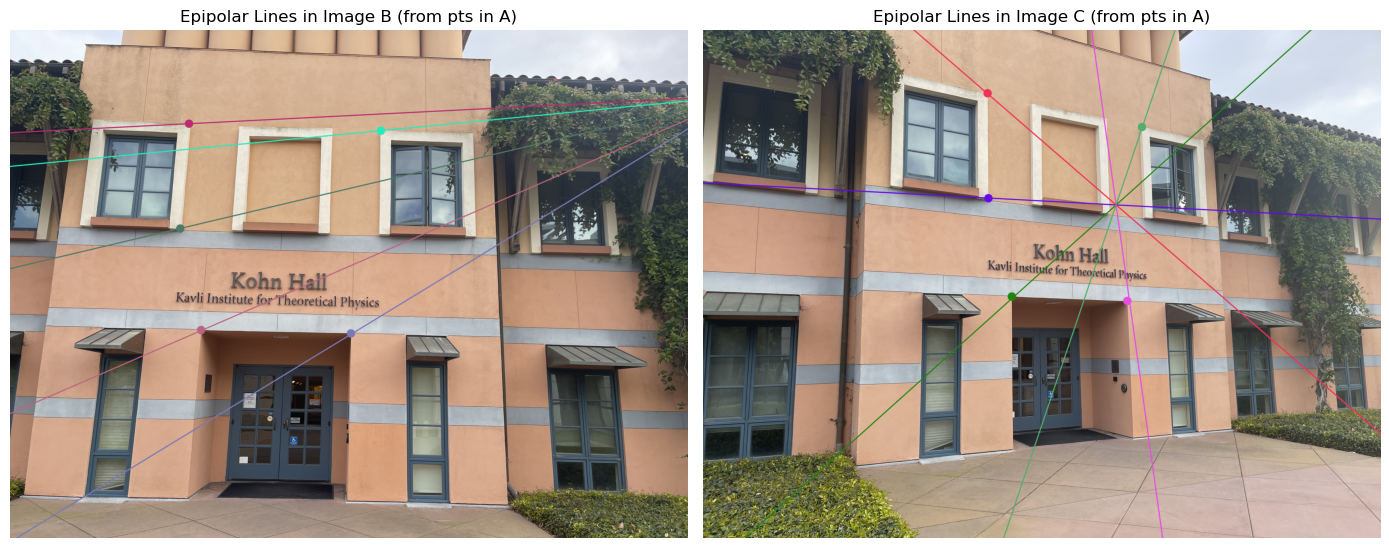

In [136]:
draw_epipolar_lines(img_A, img_B, img_C, pts_A[10:], pts_B[10:], pts_C[10:], F_AB, F_CA.T)

4. Cross-View Consistency Check (Epipolar Intersection in B): 

In [137]:
def draw_epipolar_line(line, img_shape, color='r', label=None):
    a, b, c = line
    h, w = img_shape[:2]

    if abs(b) > 1e-6:
        x1, x2 = 0, w
        y1 = int((-c - a * x1) / b)
        y2 = int((-c - a * x2) / b)
    else:
        # Vertical line
        x1 = x2 = int(-c / a)
        y1, y2 = 0, h

    return (x1, y1), (x2, y2)

def visualize_epipolar_intersection(F_AB, F_CB, pt_A, pt_C, gt_B, image_B):
    """
    :param F_AB: Fundamental matrix from A to B
    :param F_CB: Fundamental matrix from C to B
    :param pt_A: point in A (x, y)
    :param pt_C: point in C (x, y)
    :param gt_B: ground-truth point in B (x, y)
    :param image_B: image array
    """
    pt_A_h = np.array([*pt_A, 1.0])
    pt_C_h = np.array([*pt_C, 1.0])

    l1 = F_AB @ pt_A_h  # Epipolar line from A
    l2 = F_CB @ pt_C_h  # Epipolar line from C

    # Intersection = Cross product of epipolar lines
    pt_inter = np.cross(l1, l2)
    pt_inter = pt_inter / pt_inter[2]

    # Visualization
    img_vis = image_B.copy()
    h, w = img_vis.shape[:2]

    # Draw epipolar lines
    p1, p2 = draw_epipolar_line(l1, img_vis.shape)
    img_vis = cv2.line(img_vis, p1, p2, (0, 0, 255), 5)  # Red line

    p3, p4 = draw_epipolar_line(l2, img_vis.shape)
    img_vis = cv2.line(img_vis, p3, p4, (255, 0, 0), 5)  # Blue line

    # Predicted intersection point
    cv2.circle(img_vis, tuple(np.int32(pt_inter[:2])), 20, (0, 0, 255), -1) # Red dot
    # Ground truth
    cv2.circle(img_vis, tuple(np.int32(gt_B)), 20, (0, 255, 0), -1) # Green dot

    # Error
    pixel_error = np.linalg.norm(pt_inter[:2] - gt_B)
    print(f"Pixel Error = {pixel_error:.2f} pixels")

    # Display image
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title("Epipolar Lines and Intersection in Image B")
    plt.axis('off')
    plt.show()


Pixel Error = 1.94 pixels


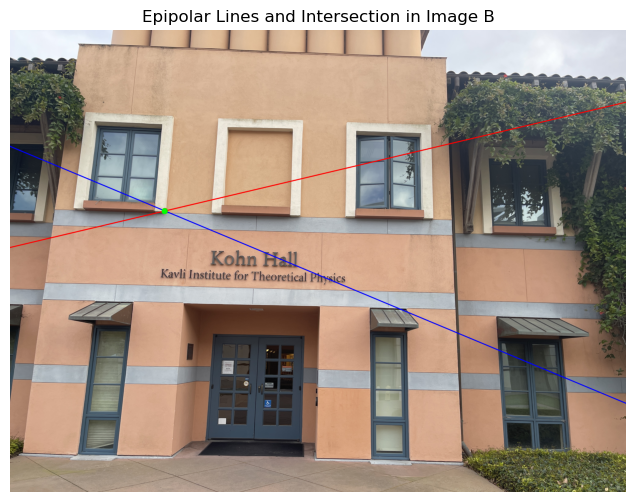

In [138]:
visualize_epipolar_intersection(F_AB, F_BC.T, pts_A[10], pts_C[10], pts_B[10], img_B)